Описание проекта 
Цель: разработать модель машинного обучения для предсказания судьбы стартапов

Задача: Обучить модель, проанализировать тестовые данные и сделать предсказание, какие из указанных 
    стартапов закроются, а какие продолжат существование. 
    Оценка качества модели - F1 score, с равнозначно высокими метриками recall и precision

План проекта:

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [51]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [50]:
import catboost

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import seaborn as sns
#from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,RandomizedSearchCV 
#from sklearn.linear_model import (LinearRegression, LogisticRegression)
#from sklearn.preprocessing import (
 #   OneHotEncoder,
  #  StandardScaler,
   # OrdinalEncoder, 
    #MinMaxScaler, 
    #RobustScaler
#)
from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
#from sklearn.impute import SimpleImputer
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.svm import SVC
#from sklearn.feature_selection import SelectKBest, f_classif
#import re
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from phik import phik_matrix
from phik.report import plot_correlation_matrix
#from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from sklearn.dummy import DummyRegressor
#from sklearn.feature_extraction.text import CountVectorizer

import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score

## Загрузка данных

In [4]:
#Тренировочная выборка
train_df = pd.read_csv('kaggle_startups_train_28062024.csv')

#Тестовая выборка
test_df = pd.read_csv('kaggle_startups_test_28062024.csv')


In [5]:
#вывод общей информации по трейн
display (train_df.head(5))
print(train_df.info())
train_df.describe()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None


,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [7]:

#проверка на дубликаты 
print(train_df['name'].duplicated().sum())
print(train_df.isna().sum())
display(train_df['category_list'].value_counts())
display(train_df['status'].value_counts())
display(train_df['country_code'].value_counts())


0
name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64


category_list
Software                                                                                  3207
Biotechnology                                                                             2905
E-Commerce                                                                                1064
Mobile                                                                                     920
Clean Technology                                                                           892
                                                                                          ... 
iPad|Reviews and Recommendations|Social Television|Software|Television|Video on Demand       1
Graphics|Software|Startups                                                                   1
Curated Web|File Sharing|Graphics|PaaS                                                       1
Cloud Computing|Cloud Data Services|Databases|IaaS|Services|Software|Virtualization          1
Online Rental|Parking|Price Comparis

status
operating    47599
closed        4917
Name: count, dtype: int64

country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: count, Length: 134, dtype: int64

In [8]:
#предобработка данных
train_df['founded_at'] = pd.to_datetime(train_df['founded_at'])
train_df['first_funding_at'] = pd.to_datetime(train_df['first_funding_at'])
train_df['last_funding_at'] = pd.to_datetime(train_df['last_funding_at'])
train_df['closed_at'] = pd.to_datetime(train_df['closed_at'])


In [9]:
train_df['closed_at']= train_df['closed_at'].fillna('2018-01-01')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          52516 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [10]:
train_df['lifetime'] = (train_df['closed_at']-train_df['founded_at']).dt.days


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [12]:
test_df.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


В данных присутсвуют строки с пропущенными значениями почти по каждому полю
Пропущены значения в поле name 
Мало информации по закрытыми стартапам, всего 4000 строк против 53к общих данных

In [13]:
unique_duplicates = train_df['name'].value_counts()
duplicates = unique_duplicates[unique_duplicates > 1]

print(f'Уникальные дубликаты:\n{duplicates}')

Уникальные дубликаты:
Series([], Name: count, dtype: int64)


In [14]:
train_df = train_df.drop_duplicates(subset='name', keep='first')

## Анализ данных

In [15]:
train_df.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,2018-01-01,2452
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922


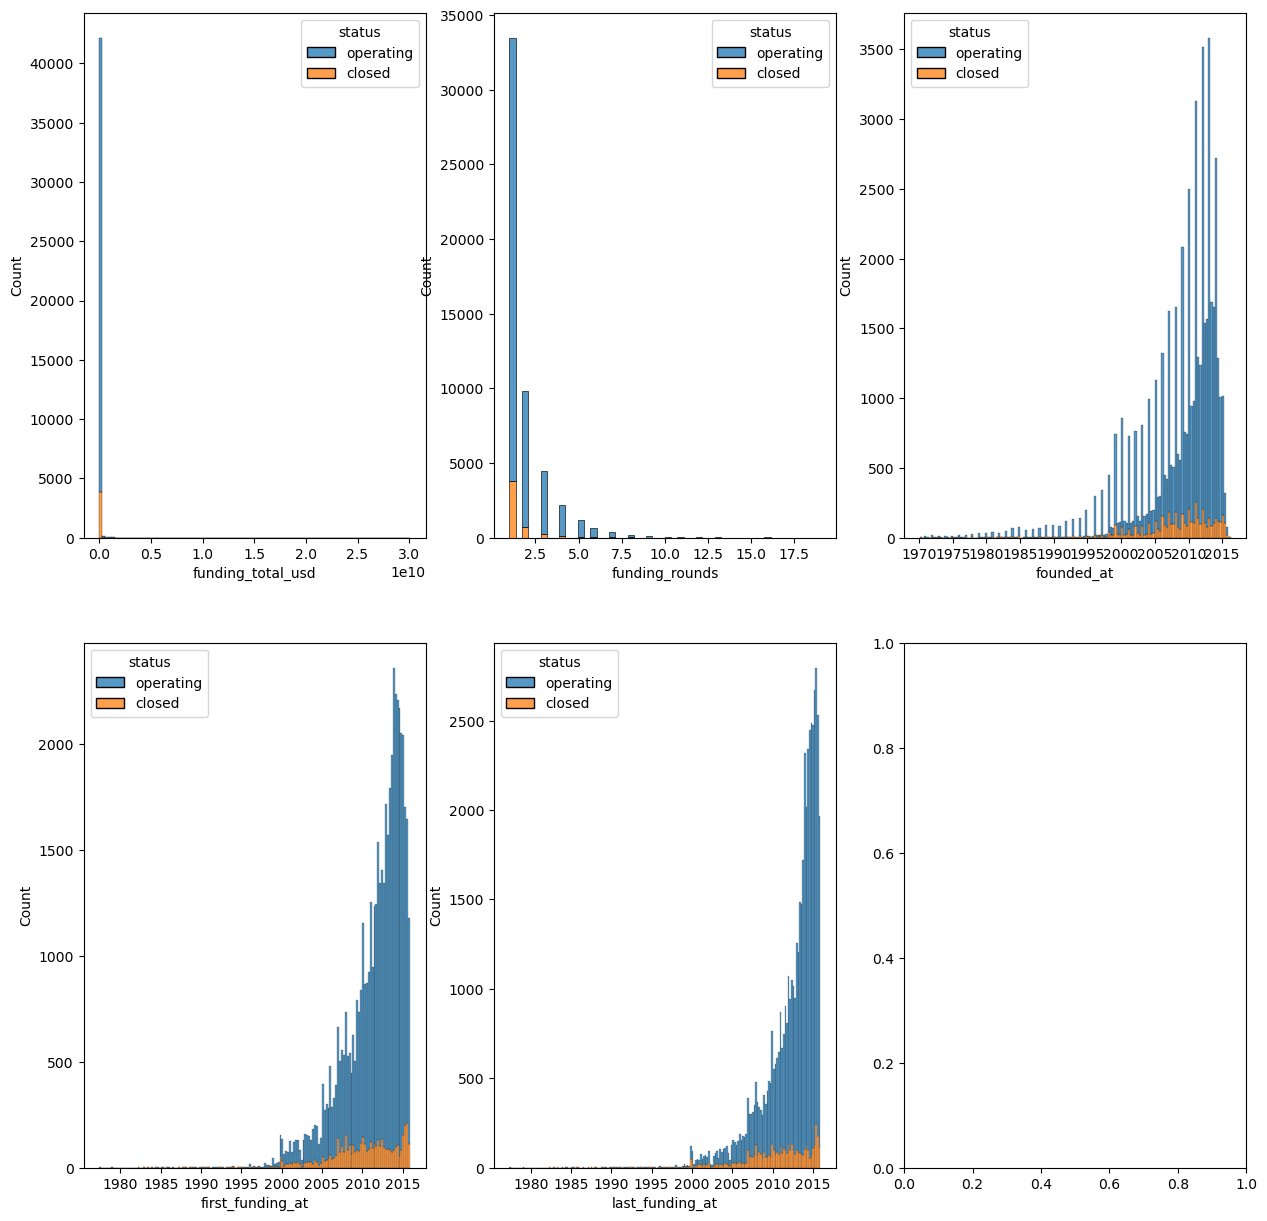

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15));

sns.histplot(data=train_df, x= 'funding_total_usd', hue='status', multiple='stack', bins=100, ax=axes[0,0]);
sns.histplot(data=train_df, x= 'funding_rounds', hue='status', multiple='stack',bins=50, ax=axes[0,1]);
sns.histplot(data=train_df, x= 'founded_at', hue='status', multiple='stack', ax=axes[0,2]);
sns.histplot(data=train_df, x= 'first_funding_at', hue='status', multiple='stack', ax=axes[1,0]);
sns.histplot(data=train_df, x= 'last_funding_at', hue='status', multiple='stack', ax=axes[1,1]);



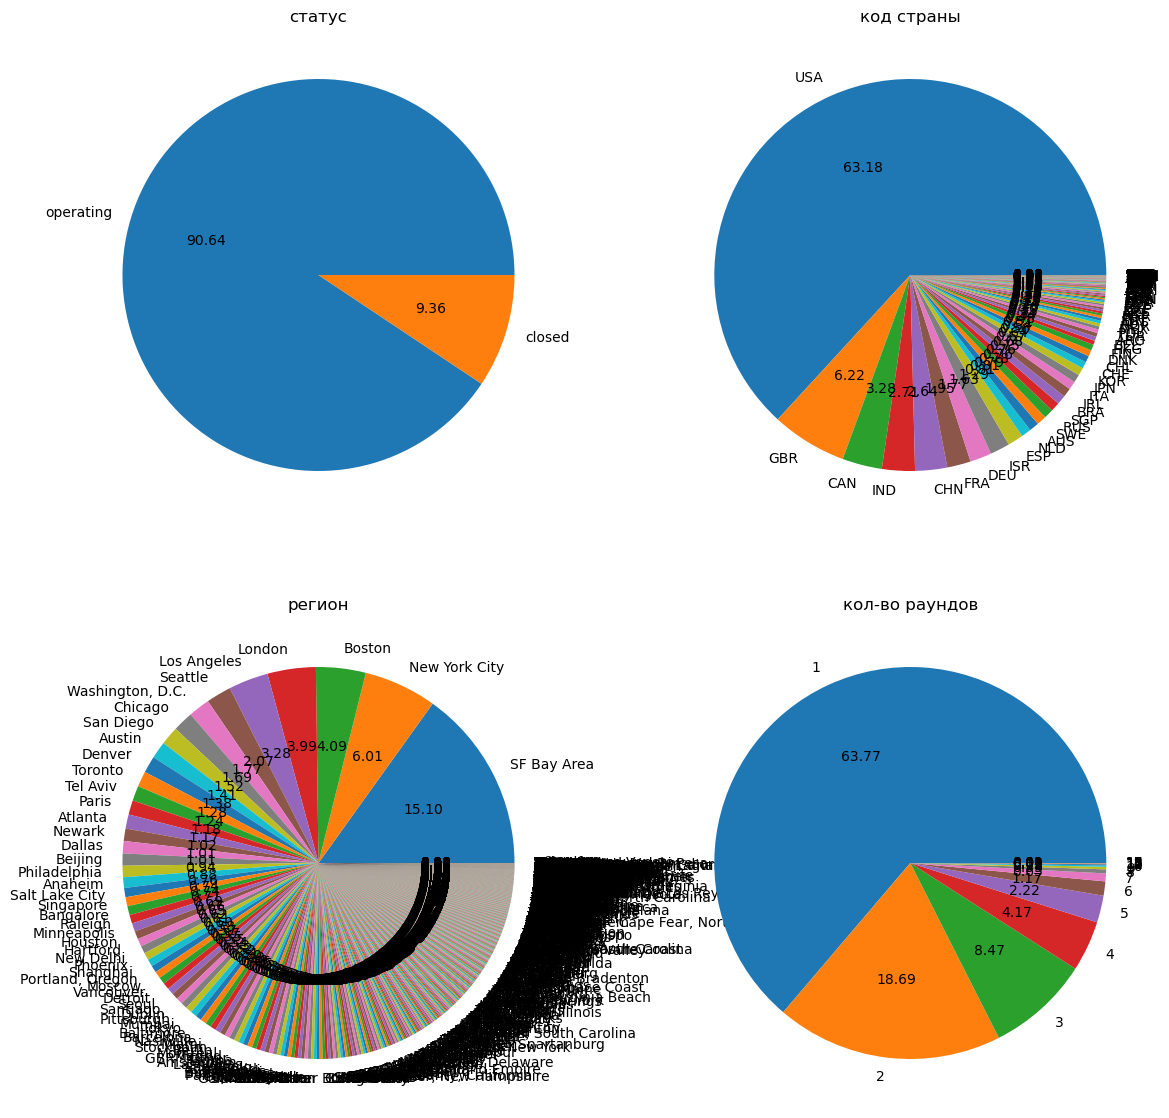

In [17]:
# анализ распределения категорийных значений (без поля категории)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7));



(train_df['status'].value_counts()
 .plot(kind='pie', ax=axes[0,0], legend=False, autopct='%.2f')
 .set(xlabel='', ylabel='', title='статус')
);
(train_df['country_code'].value_counts()
 .plot(kind='pie', ax=axes[0,1], legend=False, autopct='%.2f')
 .set(xlabel='', ylabel='', title='код страны')
);

(train_df['region'].value_counts()
 .plot(kind='pie', ax=axes[1,0], legend=False, autopct='%.2f')
 .set(xlabel='', ylabel='', title='регион')
);
(train_df['funding_rounds'].value_counts()
 .plot(kind='pie', ax=axes[1,1], legend=False, autopct='%.2f')
 .set(xlabel='', ylabel='', title='кол-во раундов')
);


Данных в поле категория слишком много для анализа, значения содержать неявные дубликаты. 
Нужно сделать категории более общими


In [18]:

train_df['category_list'].value_counts().count()


22105

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
count,4.244700e+04,52516.000000,52516,52516,52516,52516,52516.000000
mean,1.824748e+07,1.740670,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472,2017-06-11 05:36:46.504684032,3140.828129
min,1.000000e+00,1.000000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00,19.000000
25%,3.360275e+05,1.000000,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2018-01-01 00:00:00,1739.000000
50%,2.000000e+06,1.000000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2018-01-01 00:00:00,2557.000000
75%,1.000000e+07,2.000000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2018-01-01 00:00:00,4018.000000
max,3.007950e+10,19.000000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2018-01-01 00:00:00,17378.000000
std,1.871173e+08,1.374522,NaN,NaN,NaN,NaN,2147.821070


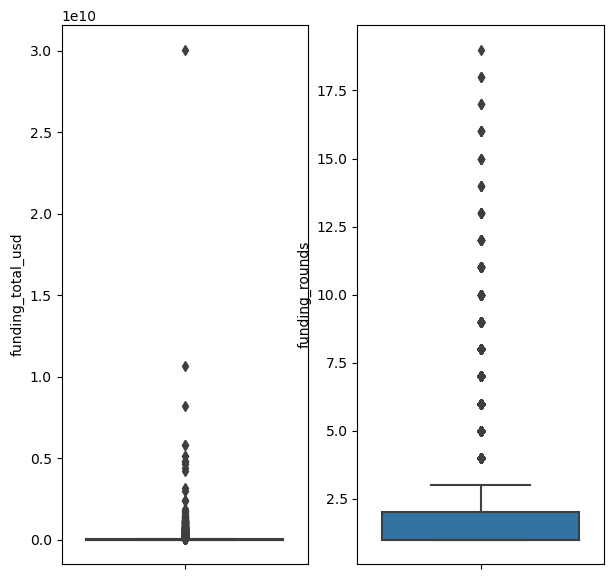

In [19]:
display(train_df.describe())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 7));
#Изучим отдельно данные с выбросами
sns.boxplot(data = train_df,y = 'funding_total_usd',ax=axes[0]);
sns.boxplot(data = train_df, y = 'funding_rounds',ax=axes[1]);

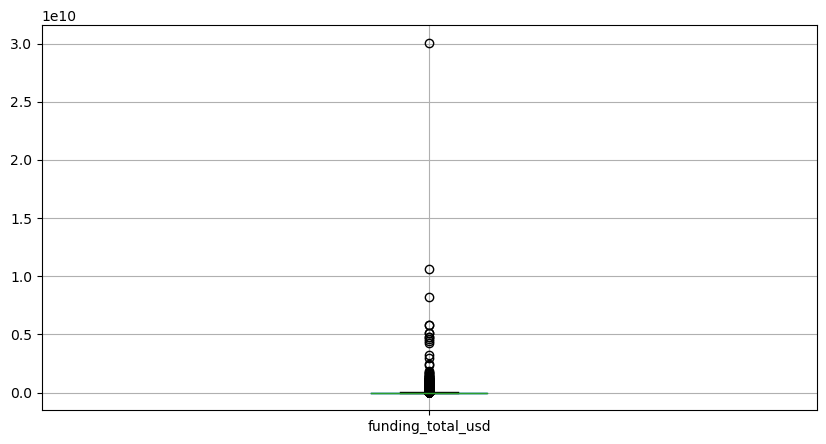

In [20]:
train_df['funding_total_usd'].max()
train_df.boxplot('funding_total_usd',figsize=(10,5));

In [21]:
index_max = train_df['funding_total_usd'].idxmax()

train_df.drop(index_max, inplace=True) 

In [22]:
train_df.info()
train_df[['name','category_list', 'country_code', 'state_code', 'region', 'city']] = train_df[['name','category_list', 'country_code', 'state_code', 'region', 'city']].fillna('Unknown')
train_df[['funding_total_usd', 'funding_rounds']] = train_df[['funding_total_usd', 'funding_rounds']].fillna(np.nan)


<class 'pandas.core.frame.DataFrame'>
Index: 52515 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52514 non-null  object        
 1   category_list      50050 non-null  object        
 2   funding_total_usd  42446 non-null  float64       
 3   status             52515 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52515 non-null  int64         
 9   founded_at         52515 non-null  datetime64[ns]
 10  first_funding_at   52515 non-null  datetime64[ns]
 11  last_funding_at    52515 non-null  datetime64[ns]
 12  closed_at          52515 non-null  datetime64[ns]
 13  lifetime           52515 non-null  int64         
dtypes: datetime

In [23]:
display(train_df.head(5))
print(train_df.info())

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383
3,Sancilio and Company,Health Care,22250000.0,operating,Unknown,Unknown,Unknown,Unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791


<class 'pandas.core.frame.DataFrame'>
Index: 52515 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      52515 non-null  object        
 2   funding_total_usd  42446 non-null  float64       
 3   status             52515 non-null  object        
 4   country_code       52515 non-null  object        
 5   state_code         52515 non-null  object        
 6   region             52515 non-null  object        
 7   city               52515 non-null  object        
 8   funding_rounds     52515 non-null  int64         
 9   founded_at         52515 non-null  datetime64[ns]
 10  first_funding_at   52515 non-null  datetime64[ns]
 11  last_funding_at    52515 non-null  datetime64[ns]
 12  closed_at          52515 non-null  datetime64[ns]
 13  lifetime           52515 non-null  int64         
dtypes: datetime

## Преобразование тренировочных данных

In [24]:


train_df['first_funding_year'] = train_df['first_funding_at'].dt.year.astype(float)
train_df['first_funding_month'] = train_df['first_funding_at'].dt.month.astype(float)
train_df['first_funding_day'] = train_df['first_funding_at'].dt.day.astype(float)

train_df['last_funding_year'] = train_df['last_funding_at'].dt.year.astype(float)
train_df['last_funding_month'] = train_df['last_funding_at'].dt.month.astype(float)
train_df['last_funding_day'] = train_df['last_funding_at'].dt.day.astype(float)


In [25]:
train_df = train_df.drop(['founded_at','first_funding_at','last_funding_at','closed_at'], axis=1)


In [26]:
train_df['funding_rounds'] = train_df['funding_rounds'].astype(float)

In [27]:
train_df[['name','category_list', 'country_code', 'state_code', 'city','region']] = train_df[['name','category_list', 'country_code', 'state_code', 'city','region']].astype('category')

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52515 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   name                 52515 non-null  category
 1   category_list        52515 non-null  category
 2   funding_total_usd    42446 non-null  float64 
 3   status               52515 non-null  object  
 4   country_code         52515 non-null  category
 5   state_code           52515 non-null  category
 6   region               52515 non-null  category
 7   city                 52515 non-null  category
 8   funding_rounds       52515 non-null  float64 
 9   lifetime             52515 non-null  int64   
 10  first_funding_year   52515 non-null  float64 
 11  first_funding_month  52515 non-null  float64 
 12  first_funding_day    52515 non-null  float64 
 13  last_funding_year    52515 non-null  float64 
 14  last_funding_month   52515 non-null  float64 
 15  last_funding_day     525

interval columns not set, guessing: ['funding_total_usd', 'funding_rounds', 'lifetime', 'first_funding_year', 'first_funding_month', 'first_funding_day', 'last_funding_year', 'last_funding_month', 'last_funding_day']


/Users/nbasina/anaconda3/lib/python3.11/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1037. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(


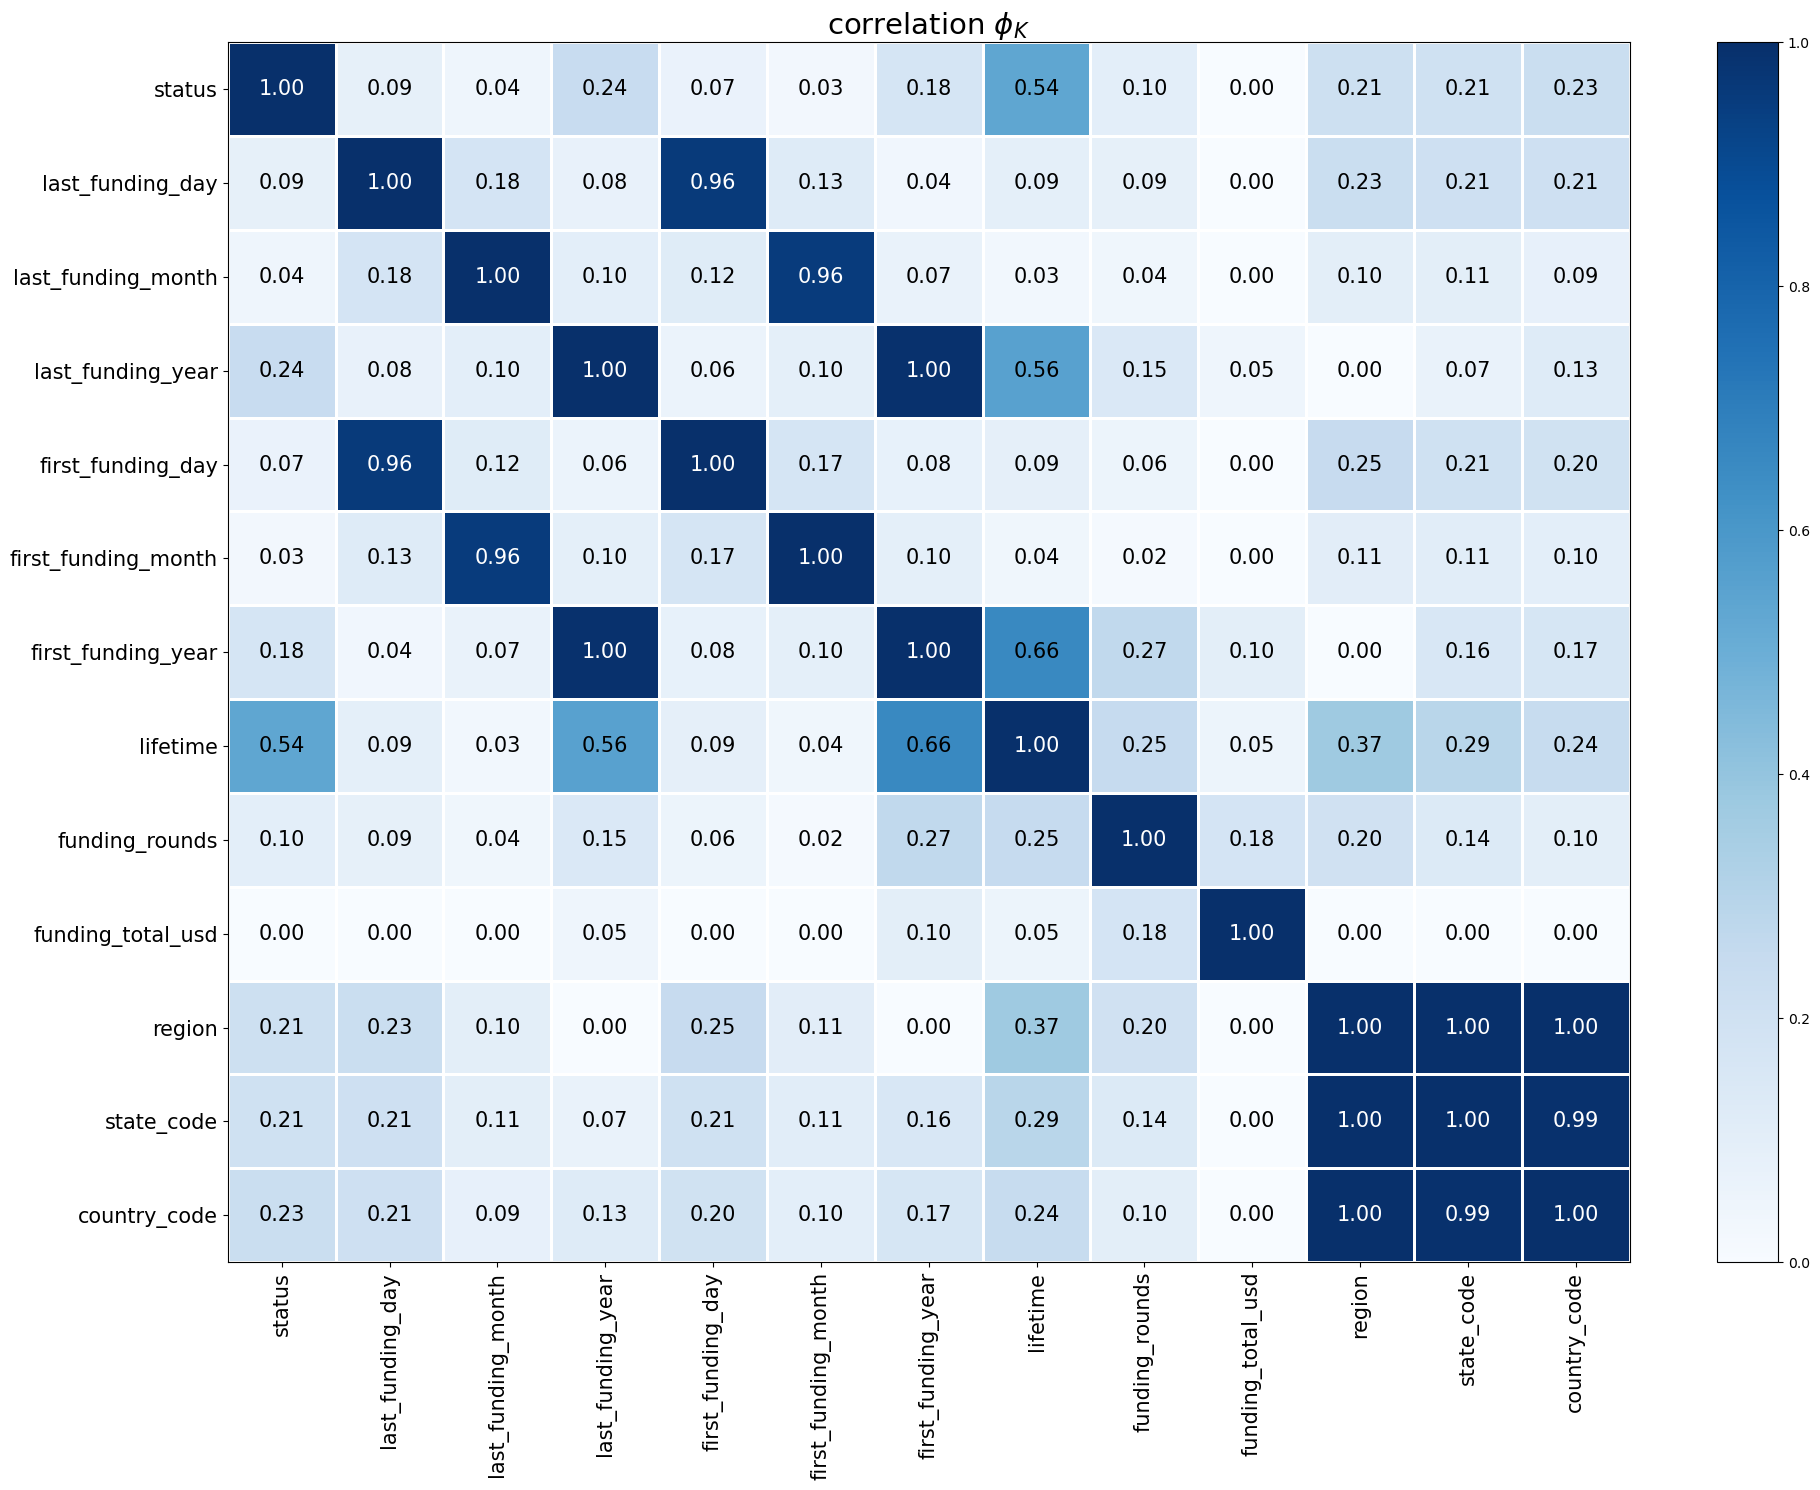

In [29]:
### матрица корреляции 
phik_overview = phik_matrix(train_df[['country_code', 'state_code','region','funding_total_usd',
                                      'funding_rounds','lifetime','first_funding_year','first_funding_month','first_funding_day',
                                     'last_funding_year','last_funding_month','last_funding_day','status']]) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 


признаки регион, код штата и страна являются мульиколлениарны, для обучения можно оставить один из них (поле регион - наиболее заполненное поле, для обучения оставим его )

In [30]:
train_df = train_df.drop(['state_code','country_code'], axis=1)

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52515 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   name                 52515 non-null  category
 1   category_list        52515 non-null  category
 2   funding_total_usd    42446 non-null  float64 
 3   status               52515 non-null  object  
 4   region               52515 non-null  category
 5   city                 52515 non-null  category
 6   funding_rounds       52515 non-null  float64 
 7   lifetime             52515 non-null  int64   
 8   first_funding_year   52515 non-null  float64 
 9   first_funding_month  52515 non-null  float64 
 10  first_funding_day    52515 non-null  float64 
 11  last_funding_year    52515 non-null  float64 
 12  last_funding_month   52515 non-null  float64 
 13  last_funding_day     52515 non-null  float64 
dtypes: category(4), float64(8), int64(1), object(1)
memory usage: 8.2+ MB


## Преобразование тестовых данных

In [32]:

test_df['first_funding_at'] = pd.to_datetime(test_df['first_funding_at'])
test_df['last_funding_at'] = pd.to_datetime(test_df['last_funding_at'])
test_df[['name','category_list', 'country_code', 'state_code', 'region', 'city']] = test_df[['name','category_list', 'country_code', 'state_code', 'region', 'city']].fillna('Unknown')
test_df[['funding_total_usd', 'funding_rounds']] = test_df[['funding_total_usd', 'funding_rounds']].fillna(np.nan)


In [33]:
test_df['first_funding_year'] = test_df['first_funding_at'].dt.year.astype(float)
test_df['first_funding_month'] = test_df['first_funding_at'].dt.month.astype(float)
test_df['first_funding_day'] = test_df['first_funding_at'].dt.day.astype(float)

test_df['last_funding_year'] = test_df['last_funding_at'].dt.year.astype(float)
test_df['last_funding_month'] = test_df['last_funding_at'].dt.month.astype(float)
test_df['last_funding_day'] = test_df['last_funding_at'].dt.day.astype(float)

In [34]:
test_df[['funding_rounds','lifetime']] = test_df[['funding_rounds','lifetime']].astype(float)

In [35]:
test_df[['name','category_list', 'country_code', 'state_code', 'city','region']] = test_df[['name','category_list', 'country_code', 'state_code', 'city','region']].astype('category')

In [36]:
test_df = test_df.drop(['first_funding_at','last_funding_at'], axis=1)


In [37]:
test_df = test_df.drop(['state_code','country_code'], axis=1)

In [38]:
test_df.head()

,name,category_list,funding_total_usd,region,city,funding_rounds,lifetime,first_funding_year,first_funding_month,first_funding_day,last_funding_year,last_funding_month,last_funding_day
0,Crystalsol,Clean Technology,2819200.0,Unknown,Unknown,1.0,3501.0,2009.0,7.0,1.0,2009.0,7.0,1.0
1,JBI Fish & Wings,Hospitality,NaN,TN - Other,Humboldt,1.0,2717.0,2010.0,7.0,28.0,2010.0,7.0,28.0
2,COINPLUS,Finance,428257.0,Esch-sur-alzette,Esch-sur-alzette,2.0,1295.0,2014.0,5.0,15.0,2014.0,9.0,18.0
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,San Diego,San Diego,4.0,4748.0,2005.0,1.0,1.0,2010.0,4.0,20.0
4,DNA13,Software,4530000.0,Ottawa,Ottawa,1.0,6209.0,2007.0,5.0,8.0,2007.0,5.0,8.0


## Обучение модели

In [39]:
train_df_target = train_df['status']
train_df = train_df.drop(['status'],axis=1)

le = LabelEncoder()
y_binary = le.fit_transform(train_df_target)

In [41]:

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    train_df, 
    y_binary, 
    test_size=0.2,  # 20% на тестовую выборку
    random_state=42
)

# Создаем и обучаем модель
model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    eval_metric='F1',
    cat_features=['name', 'category_list', 'city', 'region'],
    verbose=0  # Отключаем вывод во время обучения
)

model.fit(X_train, y_train)

# Предсказываем классы на тестовой выборке
y_pred = model.predict(X_test)

# Вычисляем F1-меру
f1 = f1_score(y_test, y_pred, average='binary') 

print(f'F1 Score: {f1}')

F1 Score: 0.9889765425003918


In [42]:
y_pred_test = model.predict(test_df)
y_pred_test = le.inverse_transform(y_pred_test)
print(y_pred_test)

['operating' 'operating' 'operating' ... 'operating' 'operating'
 'operating']


In [49]:
test_df_result = pd.DataFrame()
test_df_result['name']= test_df['name']
test_df_result['y_pred_test'] = y_pred_test
display(test_df_result)

,name,y_pred_test
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


In [52]:
test_df_result.to_csv('test_df_result.csv', index=False, header=True)

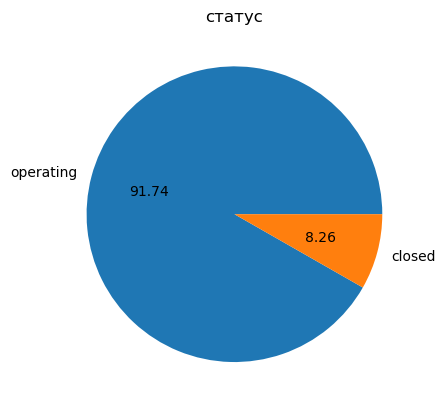

In [45]:
(test_df_result['y_pred_test'].value_counts()
 .plot(kind='pie', legend=False, autopct='%.2f')
 .set(xlabel='', ylabel='', title='статус')
);

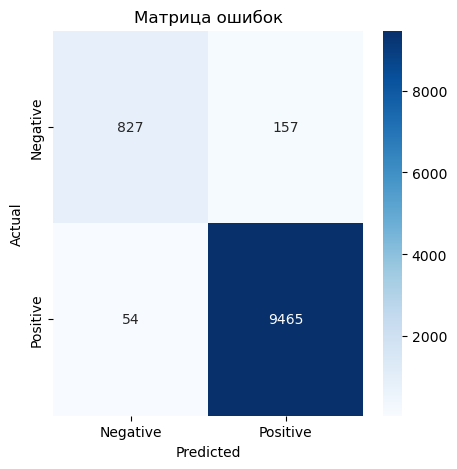

In [48]:
# Вычисление матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)


# Визуализация матрицы ошибок
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица ошибок')
plt.show()

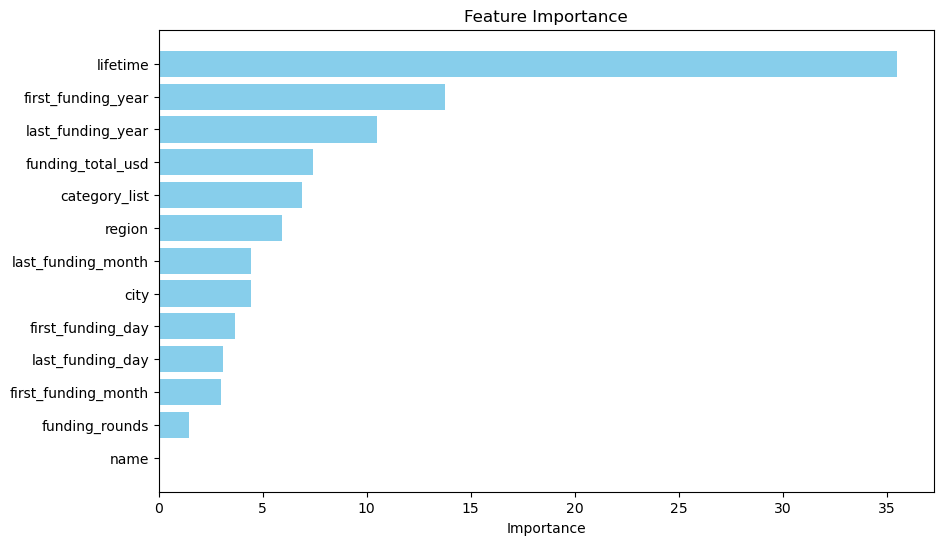

In [47]:
# Получаем важность признаков
feature_importances = model.get_feature_importance()

# Создаем DataFrame для визуализации
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Сортируем DataFrame по важности
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Визуализируем важность признаков
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

## Выводы

В рамках задания была обучена модель CatBoostClassifier, так как данная модель умеет сама анализировать большое 
кол-во категорийных данных. 

Для обучения модели были обработаны тестовые и тренировочные данные: 
- добавлено поле liftime в тренировочные данные, которое расчитывалось исходя из даты закрытия стартапа и текущей даты (или дата формирования датасета) 
- удалены мультиколлениарные признаки, такие как код страны и код региона) 
- удалены дубликаты по полю name 
- заполнены категорийный пропуски категорией Unknown
- типа данны приведены в сategory и float

Тренировочная выборка была разделена на на тренировочную и валидационную в соотношении 80/20. 
В качестве оценки каечества модели была выбрана F1, результат на валидационной выборке 0.98
Наиболее важный фактор для модели оказался lifetime, не смотря на то что у статуса и этого поля средняя корреляция. 
также важными признакми оказались 
- год первого финансирования 
- год последнего финансирования 

В тестовой выборке процент закрытых стартапов 8.2% 
Сформирован датасет с предсказаниями. 